# The averaged Kepler problem

We consider the Hamiltonian

$$
    H(r, \theta, p_r, p_\theta) = v p_\theta + \Vert p \Vert_{g}
$$

where $v$ is a constant, $p = (p_r, p_\theta)$, and $\Vert \cdot \Vert_{g}$ is the norm induced by the metric

$$
    g = \mathrm{d}r^2 + m_\lambda^2(r)\, \mathrm{d}\theta^2, \quad 
    m_\lambda^2(r) = \frac{\sin^2 r}{1 - \lambda \sin^2 r}
$$

with $\lambda = 4/5$.

Along the geodesics, we have $H+p^0 = 0$. The parameter $p^0$ is constant equal to $-1$ (hyperbolic), $0$ (abnormal) or $1$ (elliptic).

**Remark.** We can parameterize the geodesics by the norm of the initial convector, setting $\Vert{p_0}\Vert_g = 1$. 
This amounts to parameterize by the initial angle $\alpha_0$:
$$
    p_r = \sin \alpha_0, \quad p_\theta = m_\lambda(r) \cos \alpha_0.
$$
In that case, the hyperbolic geodeics are given by
$$
    p_\theta\, v + 1 = v\, m_\lambda(r) \cos \alpha_0 + 1 > 0.  
$$

## Packages

In [1]:
import sys
sys.path.insert(1, '../')
#
import math
import numpy as np              # scientific computing tools
import wrappers                 # for compilation of Fortran Hamiltonian codes
import geometry2d.database
import geometry2d.conjugate
import geometry2d.errors
import geometry2d.geodesic
import geometry2d.plottings
import geometry2d.problem
import geometry2d.splitting
import geometry2d.utils
import geometry2d.wavefront
import nutopy as nt
import scipy
import matplotlib.pyplot as plt # for plots
%matplotlib inline

In [2]:
#
color_hyperbolic = 'red'
color_elliptic   = 'blue'
color_abnormal   = 'green'
color_cut_locus  = 'black'
color_conjugate  = 'magenta'
color_wavefront  = 'orange' 
#
color_strong_domain_2d = 'lightblue'
color_strong_domain_3d = 'black'
#
PLANE = geometry2d.plottings.Coords.PLANE
SPHERE = geometry2d.plottings.Coords.SPHERE

## Fortran Hamiltonian code

In [3]:
# print Fortran code of the Hamiltonian: print hfun.f90 file
with open('hfun.f90', 'r') as f:
    print(f.read())

! Kepler
subroutine hfun(x, p, v, h)

    double precision, intent(in)  :: x(2), p(2), v
    double precision, intent(out) :: h

    ! local variables
    double precision :: r, th, pr, pth
    double precision :: l, m

    r   = x(1)
    th  = x(2)

    pr  = p(1)
    pth = p(2)

    l   = 4d0/5d0
    m   = sqrt(sin(r)**2/(1d0-l*sin(r)**2))

    h   = v*pth + sqrt(pr**2 + (pth/m)**2)

end subroutine hfun


## Initializations

In [4]:
def m2(r, λ):
    return np.sin(r)**2/(1.0-λ*np.sin(r)**2)

λ_Kepler = 4.0/5.0

def g2_Kepler(r):
    return m2(r, λ_Kepler)

def initialize(v, r0):

    # Parameters
    θ0 = 0.0        # initial latitude
    t0 = 0.0        # initial time

    name = 'lindblad_strong' # name of the problem

    # Initialize data
    data_file = 'data_kepler_strong.json'
    restart   = False # restart or not the computations
    data      = geometry2d.database.Data({'name': name,
                        't0': t0, 
                        'r0': r0, 
                        'θ0': θ0, 
                        'v': v}, data_file, restart)

    # Initial point
    q0 = np.array([r0, θ0])

    # Hamiltonian and derivatives up to order 3
    H = wrappers.hamiltonian(v, compile=False, display=False)

    # The Riemannian metric associated to the Zermelo problem
    # g = g1 dr^2 + g2 dθ^2
    def g(q):
        #λ  = 4.0/5.0
        r  = q[0] 
        g1 = 1.0
        g2 = g2_Kepler(r)
        return g1, g2

    # problem
    prob = geometry2d.problem.GeometryProblem2D(name, H, g, t0, q0, data, steps_for_geodesics=200)
    
    return prob

In [5]:
# function to plot the domain of strong current between two angles r1 and r2
def plot_2d_domain(fig, r1, r2):
    # from r to phi
    def phi(r):
        return r - np.pi/2.0
    ph1 = phi(r1)
    ph2 = phi(r2)
    # plot the domain: a 2d surface
    ax = fig.axes[0]
    xlims = ax.get_xlim()
    x  = np.linspace(xlims[0], xlims[1], 100)
    y1 = np.ones_like(x)*ph1
    y2 = np.ones_like(x)*ph2
    ax.fill_between(x, y1, y2, color=color_strong_domain_2d, alpha=0.5)
    return fig  

In [6]:
def plot_3d_domain(fig, r1, r2):
    # from r to phi
    def phi(r):
        return r - np.pi/2.0
    φ1 = phi(r1)
    φ2 = phi(r2)
    # plot the domain: a 2d surface between the parallel of latitude φ1 and φ2 on the sphere
    ax = fig.axes[0]
    # 
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(φ1, φ2, 100)
    x = np.outer(np.cos(u), np.cos(v))
    y = np.outer(np.sin(u), np.cos(v))
    z = np.outer(np.ones(np.size(u)), np.sin(v))
    #
    ax.plot_surface(x, y, z, color=color_strong_domain_3d, alpha=0.5)
    return fig

## Parameterization of the geodesics

In [7]:
# we parameterize ||p(0)|| = 1 by the angle α0
# the norm being given by the metric g: p(0) = (sin(α0)*g1, cos(α0)*g2) = (sin(α0), cos(α0)*g2), since g1 = 1
# get the values of α0 for which h = ptheta v + 1 > 0
#
# first get the values of α for which h = ptheta v + 1 = 0
# since ptheta = m(r) cos(α0) we wil need to check if v m(r) > 1
# m(r) = sqrt(g2_Kepler(r))
def K(r, v):
    return v*np.sqrt(g2_Kepler(r))

def pθ(r, α):
    return np.cos(α)*np.sqrt(g2_Kepler(r))

def h(r, α, v):
    return pθ(r, α)*v + 1.0

def α0(r, v):
    return np.arccos(-1.0/K(r, v))

# get the values of α0 for which h > 0
def α_hyperbolique_1(r, v):
    k = K(r, v)
    if abs(k) > 1.0:
        α = α0(r, v) # between 0 and pi
        if α < np.pi/2.0:
            return α
        else:
            return 2.0*np.pi - α
    else:
        return 0.0

def α_hyperbolique_2(r, v):
    k = K(r, v)
    if abs(k) > 1.0:
        α = α0(r, v) # between 0 and pi
        if α < np.pi/2.0:
            return 2.0*np.pi - α
        else:
            return α + 2.0*np.pi
    else:
        return 2.0*np.pi

def α_hyperbolique_span(r, v, *, N=20):
    α1 = α_hyperbolique_1(r, v)
    print('α1 = ', α1)
    α2 = α_hyperbolique_2(r, v)
    print('α2 = ', α2)
    return np.linspace(α1, α2, N)

# get the values of α0 for which h < 0
def α_elliptique_1(r, v):
    k = K(r, v)
    if abs(k) > 1.0:
        α = α0(r, v) # between 0 and pi
        if α < np.pi/2.0:
            return 2.0*np.pi - α
        else:
            return α
    else:
        # raise an error: there is no elliptic domain
        raise geometry2d.errors.ArgumentValueError('There is no elliptic domain for this value of v')
    
def α_elliptique_2(r, v):
    k = K(r, v)
    if abs(k) > 1.0:
        α = α0(r, v) # between 0 and pi
        if α < np.pi/2.0:
            return α + 2.0*np.pi
        else:
            return 2.0*np.pi - α
    else:
        # raise an error: there is no elliptic domain
        raise geometry2d.errors.ArgumentValueError('There is no elliptic domain for this value of v')
    
def α_elliptique_span(r, v, *, N=20):
    α1 = α_elliptique_1(r, v)
    print('α1 = ', α1)
    α2 = α_elliptique_2(r, v)
    print('α2 = ', α2)
    return np.linspace(α1, α2, N)

def α_abnormals(r, v):
    k = K(r, v)
    if abs(k) >= 1.0:
        α = α0(r, v)
        if α < np.pi/2.0:
            return np.array([α, -α])
        else:
            return np.array([α, 2.0*np.pi-α])
    else:
        # raise an error: there is no abnormals geodesics
        raise geometry2d.errors.ArgumentValueError('There is no abnormals geodesics for this value of v')
    
def domain_strong_current(v):
    r1 = math.asin(np.sqrt(1.0/(λ_Kepler+v**2)))
    r2 = np.pi - r1
    return r1, r2

## Problem definition

In [8]:
v    = 0.8
r0   = np.pi/2.0
prob = initialize(v, r0)
geodesic = geometry2d.geodesic.Geodesic(prob)
r1_strong, r2_strong = domain_strong_current(v) # Domain of strong current

## Geodesic flow

In [9]:
αspan_hyperbolique = α_hyperbolique_span(r0, v, N=21)
tf = geodesic.return_to_equator

#
fig2d = geodesic.plot(alphas=αspan_hyperbolique, tf=tf, length=1.0, view=PLANE, figsize=(5,5), color=color_hyperbolic)
ax_2d = fig2d.axes[0]
ax_2d.set_xlim(-np.pi/3, 2*np.pi + np.pi/3)
ax_2d.axvline(2*np.pi, color='k', linewidth=0.5, linestyle="dashed", zorder=geometry2d.plottings.z_order_axes)
fig2d = plot_2d_domain(fig2d, r1_strong, r2_strong)

# cameras is a list of dictionaries containing azimuth and elevetion angles
cameras=[{'azimuth': 140, 'elevation': -10}]
figs3d = []
for cam in cameras:
    azimuth = cam['azimuth']
    elevation = cam['elevation']
    fig3d = geodesic.plot(alphas=αspan_hyperbolique, tf=tf, length=1.0, view=SPHERE, 
                          azimuth=azimuth, elevation=elevation, figsize=(3,3),
        color=color_hyperbolic)
    fig3d = plot_3d_domain(fig3d, r1_strong, r2_strong)
    figs3d.append(fig3d)

α1 =  4.119189204235061
α2 =  8.447181410124111


<Figure size 640x480 with 0 Axes>

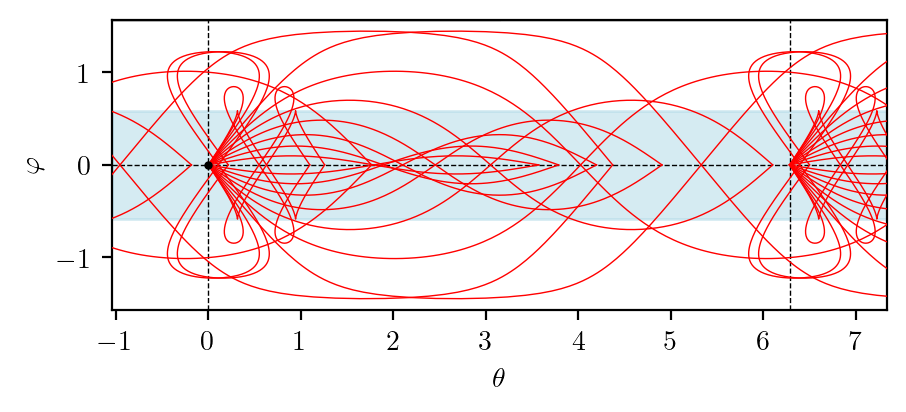

In [10]:
fig2d

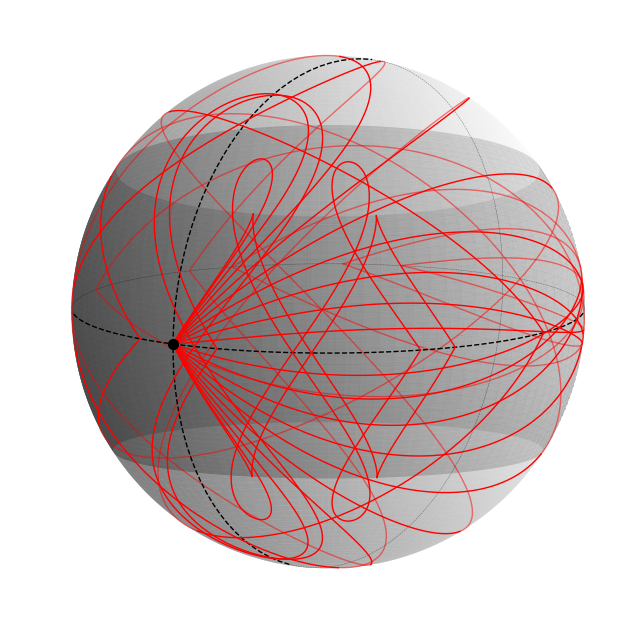

In [11]:
figs3d[0]

### Abnormal geodesics

In [12]:
α1a, α2a = α_abnormals(r0, v)
print('α1a = ', α1a)
print('α2a = ', α2a)

α1a =  2.1639961029445254
α2a =  4.119189204235061


In [13]:
tf = geodesic.return_to_equator

#
fig2d = geodesic.plot(alphas=[α1a, α2a], tf=tf, length=1.0, view=PLANE, figsize=(5,5), color=color_abnormal)
ax_2d = fig2d.axes[0]
ax_2d.set_xlim(-np.pi/3, 2*np.pi + np.pi/3)
ax_2d.axvline(2*np.pi, color='k', linewidth=0.5, linestyle="dashed", zorder=geometry2d.plottings.z_order_axes)
fig2d = plot_2d_domain(fig2d, r1_strong, r2_strong)

# cameras is a list of dictionaries containing azimuth and elevetion angles
cameras=[{'azimuth': 140, 'elevation': -10}]
figs3d = []
for cam in cameras:
    azimuth = cam['azimuth']
    elevation = cam['elevation']
    fig3d = geodesic.plot(alphas=[α1a, α2a], tf=tf, length=1.0, view=SPHERE, 
                          azimuth=azimuth, elevation=elevation, figsize=(3,3), color=color_abnormal)
    fig3d = plot_3d_domain(fig3d, r1_strong, r2_strong)
    figs3d.append(fig3d)

<Figure size 640x480 with 0 Axes>

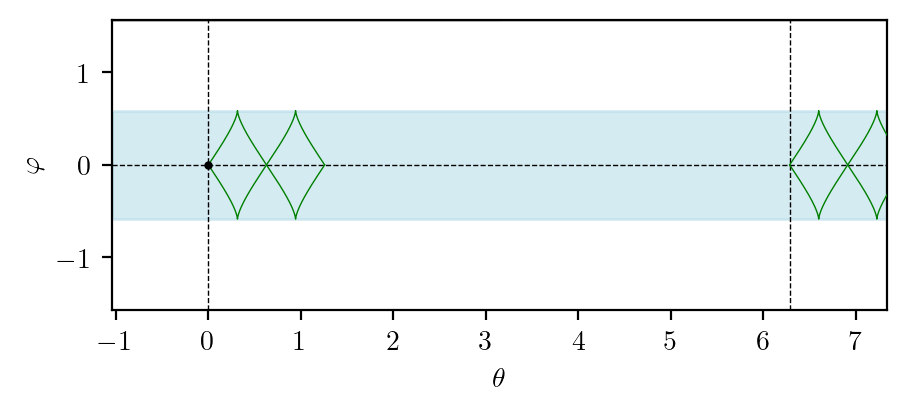

In [14]:
fig2d

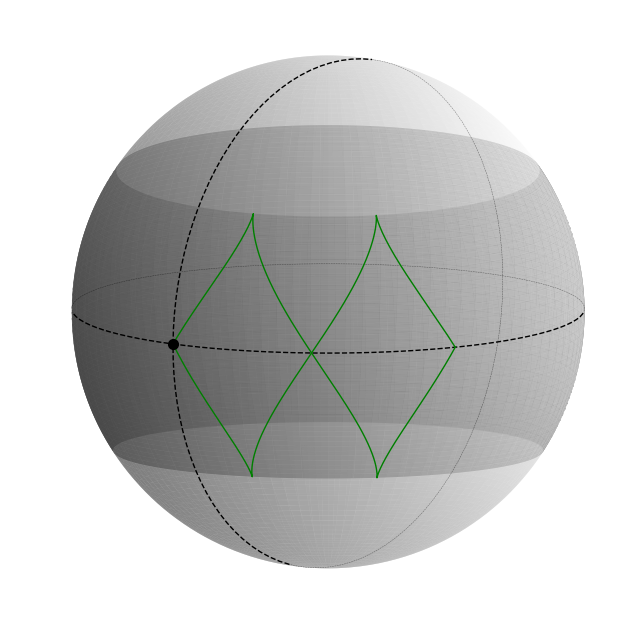

In [15]:
figs3d[0]

### Hyperbolic geodesics

In [16]:
# the separatrices between hyperbolic with loops and hyperbolic without loops is given by pθ = 0

# without loops:
αs_no_loops = np.linspace(0.0, np.pi/2, 5)
αs_no_loops = αs_no_loops[[1,3]]

# with loops
αe1 = α_elliptique_1(r0, v)
αs_loops = np.linspace(np.pi/2, αe1, 7)
αs_loops = αs_loops[[1,4]]

# concatenate
αs = np.concatenate((αs_no_loops, αs_loops))

#
tf = geodesic.return_to_equator

#
fig2d = geodesic.plot(alphas=αs, tf=tf, view=PLANE, color=color_hyperbolic, figure=fig2d)

#
for fig3d in figs3d:
    geodesic.plot(alphas=αs, tf=tf, view=SPHERE, color=color_hyperbolic, figure=fig3d)


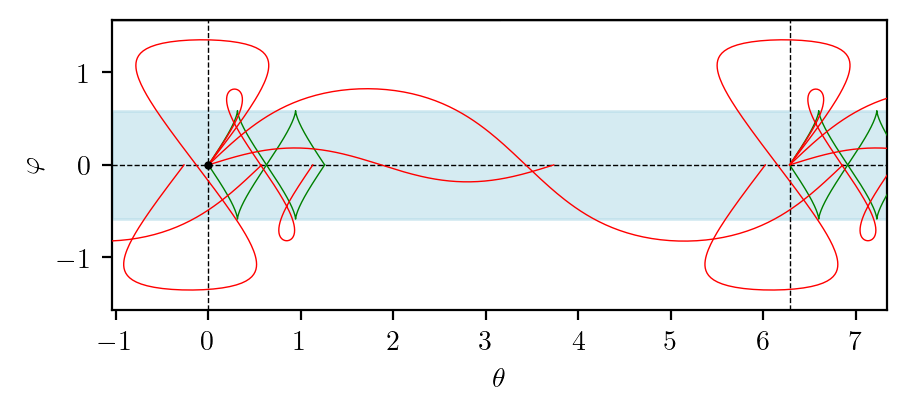

In [17]:
fig2d

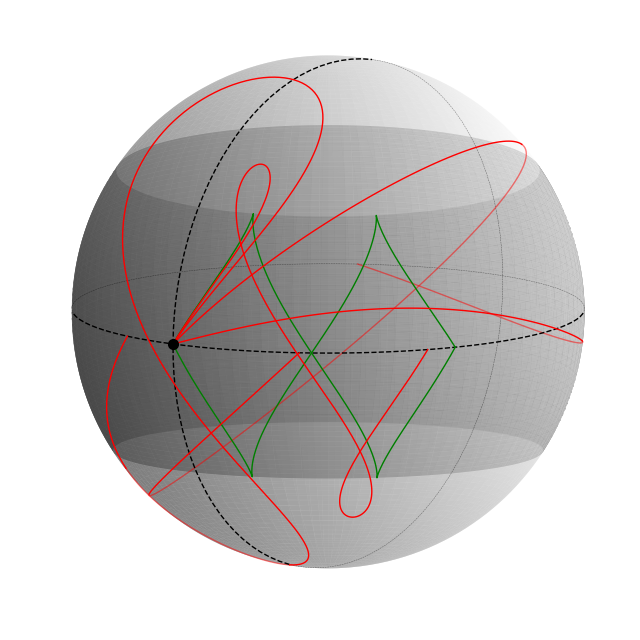

In [18]:
figs3d[0]

In [19]:
# get the values of α0 for which the hyperbolic geodesics return to the initial point
def myfun_return_to_initial(y):
    t, α0 = y
    q = prob.geodesic(t, α0)
    return q[0] - q[-1]

t_loop_guess  = 3.0
# α0_loop_guess = middle of pi/2 and abnormal given by α1a
α0_loop_guess = 1.7 #(np.pi/2 + α1a)/2.0

y_guess = np.array([t_loop_guess, α0_loop_guess])
sol = nt.nle.solve(myfun_return_to_initial, y_guess)

t_loop_return_to_initial   = sol.x[0]
α_loop_return_to_initial_1 = sol.x[1]
α_loop_return_to_initial_2 = 2*np.pi - α_loop_return_to_initial_1



     Calls  |f(x)|                 |x|
 
         1  5.651442610204609e-02  3.448187929913334e+00
         2  3.055349141119294e-05  3.483630790700333e+00
         3  3.106629222756182e-07  3.483618968834663e+00
         4  7.495891880478653e-11  3.483618817869363e+00
         5  1.404519055154983e-14  3.483618817899530e+00

 Results of the nle solver method:

 xsol    =  [3.03970007 1.70171195]
 f(xsol) =  [-6.88338275e-15 -1.22428109e-14]
 nfev    =  5
 njev    =  1
 status  =  1
 success =  True 

 Successfully completed: relative error between two consecutive iterates is at most TolX.



### Elliptic geodesics

In [20]:
#
αe1 = α_elliptique_1(r0, v)
αs = np.linspace(αe1, np.pi, 4)
αs = αs[1:-1]

#
tf = geodesic.return_to_equator

#
fig2d = geodesic.plot(alphas=αs, tf=tf, view=PLANE, color=color_elliptic, figure=fig2d)

#
for fig3d in figs3d:
    geodesic.plot(alphas=αs, tf=tf, view=SPHERE, color=color_elliptic, figure=fig3d)


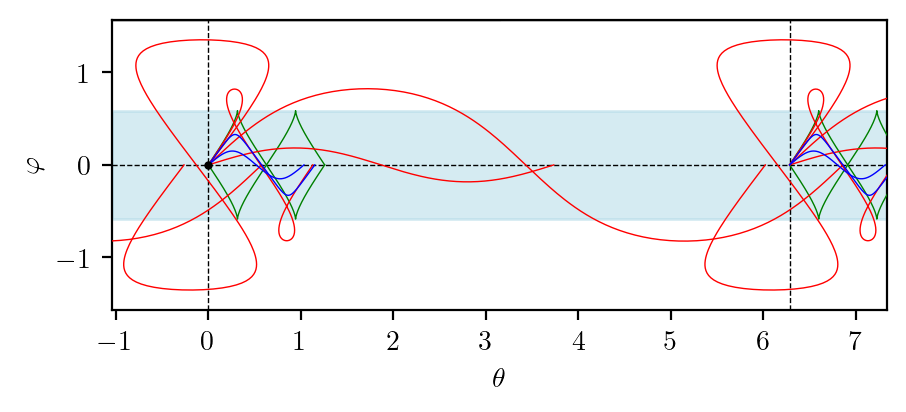

In [21]:
fig2d

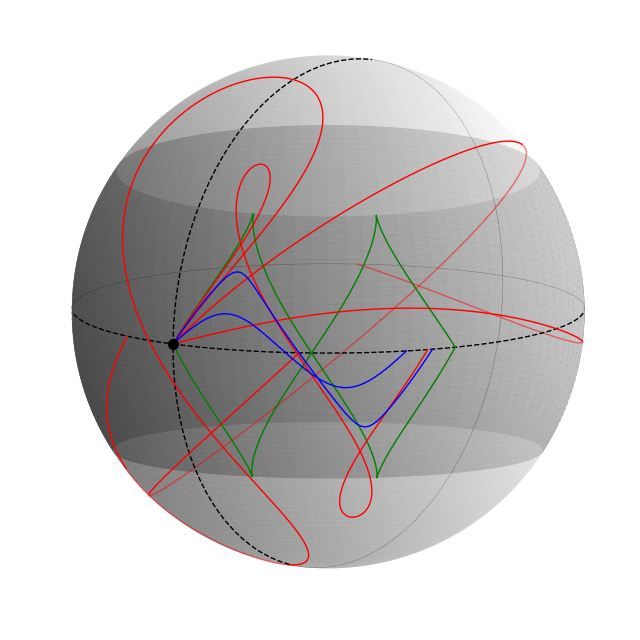

In [22]:
figs3d[0]

## Conjugate locus

In [23]:
#
gap = 1e-3

# hyperbolic whitout loops
αh_no_loops_1 = -np.pi/2 + gap
αh_no_loops_2 =  np.pi/2 - gap

# hyperbolic with loops
αh_loops_1 = np.pi/2 + gap
αh_loops_2 = α_elliptique_1(r0, v) - gap
αh_loops_3 = α_elliptique_2(r0, v) + gap
αh_loops_4 = 3.0*np.pi/2 - gap

# elliptic
αe_1 = α_elliptique_1(r0, v) + gap
αe_2 = α_elliptique_2(r0, v) - gap

In [24]:
conjugate = geometry2d.conjugate.Conjugate(prob)
conj_h_no_loops   = conjugate.compute([αh_no_loops_1, αh_no_loops_2], label='hyperbolic_without_loops')
conj_h_loop_north = conjugate.compute([αh_loops_1, αh_loops_2],       label='hyperbolic_with_loops_north')
conj_h_loop_south = conjugate.compute([αh_loops_3, αh_loops_4],       label='hyperbolic_with_loops_south')
conj_elliptic     = conjugate.compute([αe_1, αe_2],                   label='elliptic')


In [25]:
# PLANE
fig2d = conjugate.plot(['hyperbolic_without_loops', 'hyperbolic_with_loops_north', 'hyperbolic_with_loops_south'],
                        view=PLANE, color=color_conjugate, figure=fig2d, linestyle='solid', linewidth=0.8)
fig2d = conjugate.plot(['elliptic'], view=PLANE, color=color_conjugate, figure=fig2d, linestyle='dashed', linewidth=0.8)

# SPHERE
for fig3d in figs3d:
    conjugate.plot(['hyperbolic_without_loops', 'hyperbolic_with_loops_north', 'hyperbolic_with_loops_south'],
                   view=SPHERE, color=color_conjugate, figure=fig3d, linestyle='solid', linewidth=0.8)
    conjugate.plot(['elliptic'], view=SPHERE, color=color_conjugate, figure=fig3d, linestyle='dashed', linewidth=0.8)

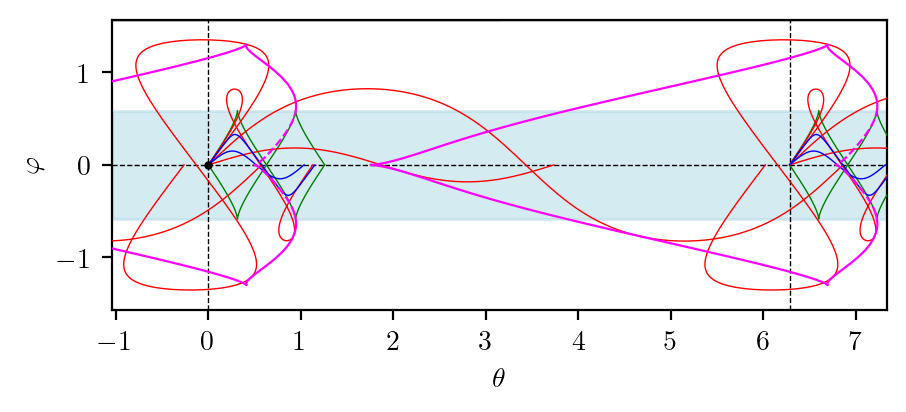

In [26]:
fig2d

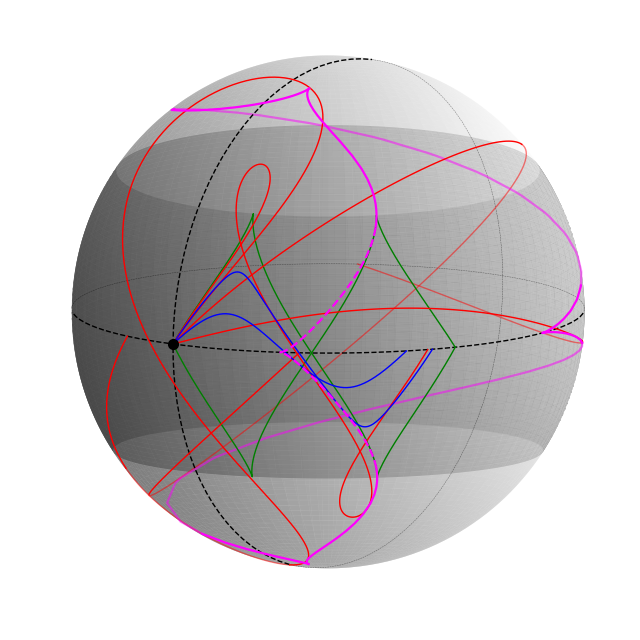

In [27]:
figs3d[0]

## Wavefronts

In [28]:
wavefront = geometry2d.wavefront.WaveFront(prob)
tfs = [1.0, 1.5, 2.0, 3.1, 3.5]
ws = []
for tf in tfs:
    ws.append(wavefront.compute(tf))

In [29]:
tfs = [1.0, 3.1]
for i in range(len(tfs)):
    tf = tfs[i]
    w  = ws[i]
    if i == 0:
        fig2d_wavefront = wavefront.plot(tf, view=PLANE, color=color_wavefront, figsize=(5,5))
        ax_2d = fig2d_wavefront.axes[0]
        ax_2d.set_xlim(-np.pi/2, 2*np.pi + np.pi/2)
        ax_2d.axvline(2*np.pi, color='k', linewidth=0.5, linestyle="dashed", zorder=geometry2d.plottings.z_order_axes)
        figs3d_wavefront = []
        for camera in cameras:
            azimuth = camera['azimuth']
            elevation = camera['elevation']
            fig3d_wavefront = wavefront.plot(tf, view=SPHERE, color=color_wavefront, 
                                             azimuth=azimuth, elevation=elevation, figsize=(3,3))
            figs3d_wavefront.append(fig3d_wavefront)
    else:
        wavefront.plot(tf, view=PLANE, color=color_wavefront, figure=fig2d_wavefront)
        for fig3d_wavefront in figs3d_wavefront:
            wavefront.plot(tf, view=SPHERE, color=color_wavefront, figure=fig3d_wavefront)

<Figure size 640x480 with 0 Axes>

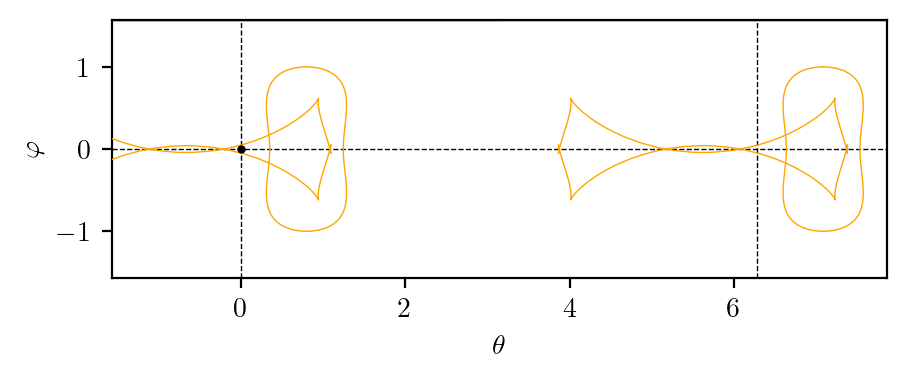

In [30]:
fig2d_wavefront

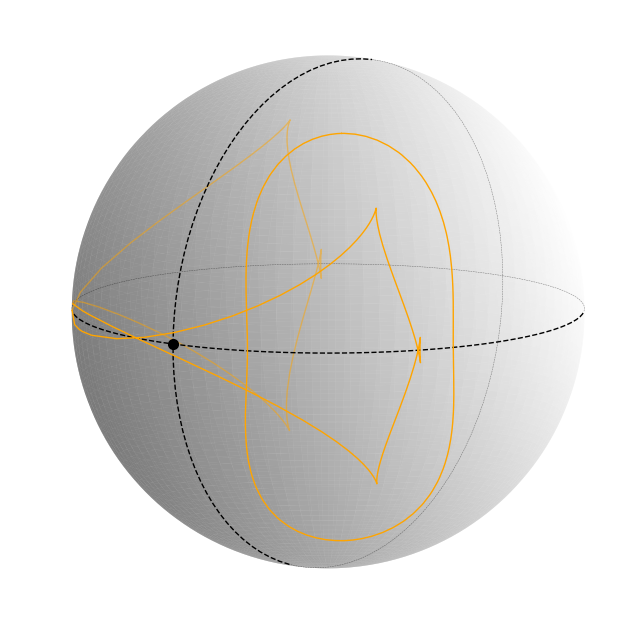

In [31]:
figs3d_wavefront[0]

## Cut locus

In [32]:
splitting = geometry2d.splitting.Splitting(prob)

In [33]:
# no loops
intersections = wavefront.self_intersections(2.0)
print(intersections['left'])
print(intersections['right'])
intersections_no_loops = intersections['right']
αspan = [0+gap, αh_no_loops_2]
print(αspan)
cut_no_loops   = splitting.compute(intersections_no_loops, αspan, label='no_loops')
t_cut_no_loops = splitting.splitting_time(cut_no_loops)

(2.0, 2.222218622020199, 4.061866589687596, array([1.57058884, 0.62521012]))
(2.0, -0.9191267057381295, 0.9203992789373718, array([1.57109573, 2.57482246]))
[0.001, 1.5697963267948967]


In [34]:
# loops: α in [α_loop_return_to_initial_1, pi/2]
intersections = wavefront.self_intersections(3.1)
print(intersections['left'])
print(intersections['right'])
intersections_loops = intersections['left']
t  = intersections_loops[0]
α1 = intersections_loops[1]
α2 = intersections_loops[2]
q  = intersections_loops[3]
intersections_loops = (t, α2, α1, q)
αspan = [α_loop_return_to_initial_1, np.pi/2+gap]
print(αspan)
cut_loops = splitting.compute(intersections_loops, αspan, label='loops')
t_cut_loops = splitting.splitting_time(cut_loops) 

(3.1, 1.6518279335268597, 4.63133677908998, array([ 1.57087215, -0.2131451 ]))
(3.1, -1.4899456366026214, 1.4900436531535355, array([1.57130931, 5.17466691]))
[1.7017119516020776, 1.5717963267948964]


In [35]:
print(α_loop_return_to_initial_2)
cut_loops.alphas

4.581473355577509


array([[4.58147336, 1.70171195],
       [4.58240506, 1.70078024],
       [4.58962422, 1.69356109],
       [4.60121676, 1.68196855],
       [4.61711398, 1.66607133],
       [4.63632337, 1.64686193],
       [4.6582413 , 1.62494401],
       [4.68249347, 1.60069184],
       [4.70907165, 1.57411366],
       [4.71138898, 1.57179633]])

## Optimal synthesis

In [36]:
# plot cut locus
fig2d_synthesis = splitting.plot(['no_loops', 'loops'], linewidth=1.0, view=PLANE, color=color_cut_locus, 
                                 figsize=(5,5))
ax_2d = fig2d_synthesis.axes[0]
ax_2d.set_xlim(-np.pi/2, 2*np.pi+np.pi/2)
ax_2d.axvline(2*np.pi, color='k', linewidth=0.5, linestyle="dashed", zorder=geometry2d.plottings.z_order_axes)
fig2d_synthesis = plot_2d_domain(fig2d_synthesis, r1_strong, r2_strong)

cameras=[{'azimuth': 140, 'elevation': -10}]
figs3d_synthesis = []
for cam in cameras:
    azimuth = cam['azimuth']
    elevation = cam['elevation']
    fig3d_synthesis = splitting.plot(['no_loops', 'loops'], linewidth=1.0, view=SPHERE, color=color_cut_locus, 
                                     azimuth=azimuth, elevation=elevation, figsize=(3,3))
    fig3d_synthesis = plot_3d_domain(fig3d_synthesis, r1_strong, r2_strong)
    figs3d_synthesis.append(fig3d_synthesis)


<Figure size 640x480 with 0 Axes>

In [37]:
# add hyperbolic conjugate points
fig2d_synthesis = conjugate.plot(['hyperbolic_with_loops_north', 'hyperbolic_with_loops_south', 
                                  'hyperbolic_without_loops'], linewidth=1.0, view=PLANE, 
                                 color=color_conjugate, figure=fig2d_synthesis, linestyle='solid')

for fig3d_synthesis in figs3d_synthesis:
    conjugate.plot(['hyperbolic_with_loops_north', 'hyperbolic_with_loops_south', 
                    'hyperbolic_without_loops'], linewidth=1.0, view=SPHERE, 
                   color=color_conjugate, figure=fig3d_synthesis, linestyle='solid')

In [38]:
# add abnormal geodesics until the cusp point defined by the boundary of the domain of strong current
α1a, α2a = α_abnormals(r0, v)
#
print('α1a = ', α1a)
print('α2a = ', α2a)
print('r1_strong = ', r1_strong)
print('r2_strong = ', r2_strong)

# the abnormal associated to α1a meets the boundary r = r2_strong
def myfun(t):
    return prob.geodesic(t, α1a)[-1][0] - (r2_strong - 1e-5)
opt = nt.nle.Options(Display='off')
t_cusp_α1a = nt.nle.solve(myfun, 1.0, options=opt).x

# the abnormal associated to α2a meets the boundary r = r1_strong
def myfun(t):
    return prob.geodesic(t, α2a)[-1][0] - (r1_strong + 1e-5)
t_cusp_α2a = nt.nle.solve(myfun, 1.0, options=opt).x

# t_cusp_abnormal
def t_cusp_abnormal(α):
    if α == α1a:
        return t_cusp_α1a
    elif α == α2a:
        return t_cusp_α2a
    else:
        raise geometry2d.errors.ArgumentValueError('α must be equal to α1a or α2a')

# plot
fig2d_synthesis = geodesic.plot(alphas=[α1a, α2a], tf=t_cusp_abnormal, view=PLANE, linewidth=1.0,
                                color=color_abnormal, figure=fig2d_synthesis)
fig2d_synthesis = geodesic.plot(alphas=[α1a, α2a], tf=t_cusp_abnormal, view=PLANE, linewidth=1.0,
                                color=color_cut_locus, linestyle='dashed', figure=fig2d_synthesis)

for fig3d_synthesis in figs3d_synthesis:
    geodesic.plot(alphas=[α1a, α2a], tf=t_cusp_abnormal, view=SPHERE, linewidth=1.0,
                  color=color_abnormal, figure=fig3d_synthesis)
    geodesic.plot(alphas=[α1a, α2a], tf=t_cusp_abnormal, view=SPHERE, linewidth=1.0,
                    color=color_cut_locus, linestyle='dashed', figure=fig3d_synthesis)

α1a =  2.1639961029445254
α2a =  4.119189204235061
r1_strong =  0.9851107833377455
r2_strong =  2.1564818702520476


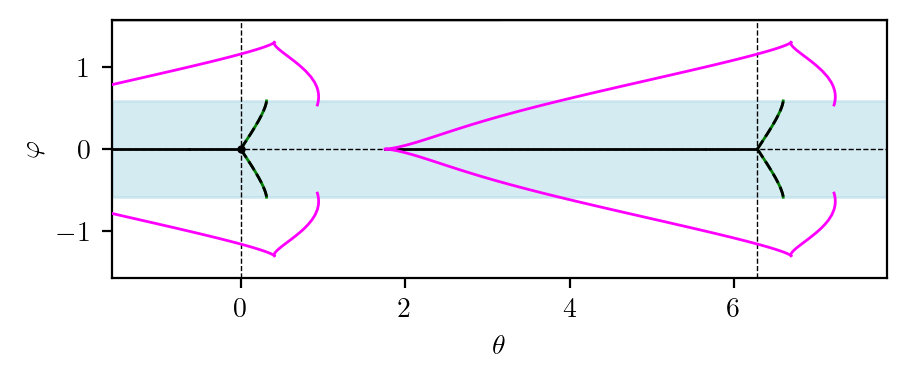

In [39]:
fig2d_synthesis

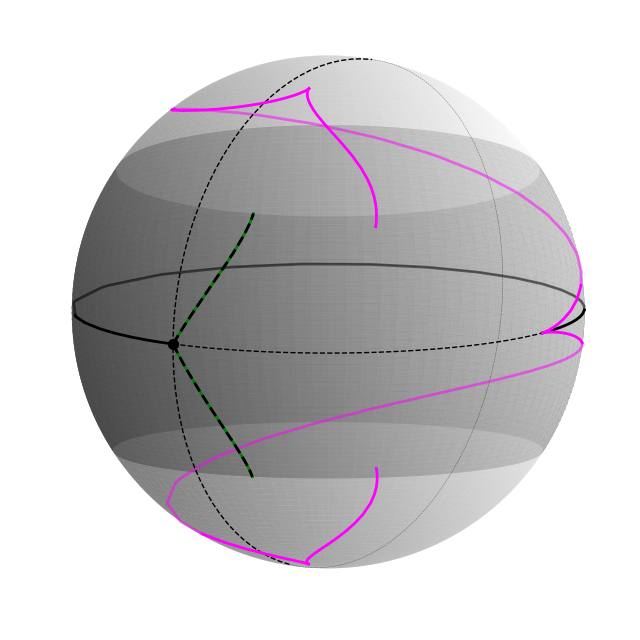

In [40]:
figs3d_synthesis[0]

In [41]:
restart_path_loop_1 = False
if prob.data.contains('path_loop_1') and not restart_path_loop_1:
    path_loop_1 = prob.data.get('path_loop_1')
    yout_loop_1 = np.array(path_loop_1['yout'])
    αout_loop_1 = np.array(path_loop_1['αout'])
    print('path_loop_1 loaded from data')
else:
    # add hyperbolic geodesics with loops until the cut point defined by the intersection with the abnormals
    # for α in [pi/2, αh_loops_1] the intersection is with the abnormal α1a
    def myfun_itersection_1(y, α):
        th, ta, r, θ = y
        q  = np.array([r, θ])
        eq = np.zeros(4)
        qf = prob.geodesic(th, α[0])[-1]
        eq[0:2] = q - qf
        eq[2:4] = q - prob.geodesic(ta, α1a)[-1]
        return eq

    # we start with α close to α1a since we know a good approximation of the intersection
    α0_ = α1a - 1e-3
    th = t_cusp_α1a
    ta = t_cusp_α1a
    q  = prob.geodesic(th, α0_)[-1]
    r  = q[0]
    θ  = q[1]

    y_guess = np.array([th, ta, r, θ])
    sol = nt.nle.solve(lambda y : myfun_itersection_1(y, [α0_]), y_guess)
    y0 = sol.x

    print('th = ', y0[0])
    print('ta = ', y0[1])
    print('t_cusp_α1a = ', t_cusp_α1a)
    sol = nt.path.solve(myfun_itersection_1, y0, [α0_], [α_loop_return_to_initial_1])
    yout_loop_1, αout_loop_1 = sol.xout, sol.parsout
    path_loop_1 = {'yout': yout_loop_1.tolist(), 'αout': αout_loop_1.tolist()}
    prob.data.update({'path_loop_1': path_loop_1})
    print('path_loop_1 saved in data')

path_loop_1 loaded from data


In [42]:
restart_path_loop_2 = False
if prob.data.contains('path_loop_2') and not restart_path_loop_2:
    path_loop_2 = prob.data.get('path_loop_2')
    yout_loop_2 = np.array(path_loop_2['yout'])
    αout_loop_2 = np.array(path_loop_2['αout'])
    print('path_loop_2 loaded from data')
else:
    # add hyperbolic geodesics with loops until the cut point defined by the intersection with the abnormals
    # for α in [pi/2, αh_loops_1] the intersection is with the abnormal α1a
    def myfun_itersection_2(y, α):
        th, ta, r, θ = y
        q  = np.array([r, θ])
        eq = np.zeros(4)
        qf = prob.geodesic(th, α[0])[-1]
        eq[0:2] = q - qf
        eq[2:4] = q - prob.geodesic(ta, α2a)[-1]
        return eq

    # we start with α close to α1a since we know a good approximation of the intersection
    α0_ = α2a + 1e-3
    th = t_cusp_α2a
    ta = t_cusp_α2a
    q  = prob.geodesic(th, α0_)[-1]
    r  = q[0]
    θ  = q[1]

    y_guess = np.array([th, ta, r, θ])
    sol = nt.nle.solve(lambda y : myfun_itersection_2(y, [α0_]), y_guess)
    y0 = sol.x

    print('th = ', y0[0])
    print('ta = ', y0[1])
    print('t_cusp_α2a = ', t_cusp_α2a)
    sol = nt.path.solve(myfun_itersection_2, y0, [α0_], [α_loop_return_to_initial_2])
    yout_loop_2, αout_loop_2 = sol.xout, sol.parsout
    path_loop_2 = {'yout': yout_loop_2.tolist(), 'αout': αout_loop_2.tolist()}
    prob.data.update({'path_loop_2': path_loop_2})
    print('path_loop_2 saved in data')

path_loop_2 loaded from data


In [43]:
# add hyperbolic geodesics with loops until the cut point defined by the intersection with the abnormals
def t_meet_abnormal(α):
    α = α % (2.0*np.pi)
    if α <= α1a and α >= α_loop_return_to_initial_1:
        times  = yout_loop_1[:, 0]
        alphas = αout_loop_1[:, 0] % (2*np.pi)
    elif α >= α2a and α <= α_loop_return_to_initial_2:
        times  = yout_loop_2[:, 0]
        alphas = αout_loop_2[:, 0]  % (2*np.pi)
    else:
        raise geometry2d.errors.ArgumentValueError('α must be in [α_loop_return_to_initial_1, α1a] U [α2a, α_loop_return_to_initial_2]')
    t_meet = scipy.interpolate.interp1d(alphas, times, kind='cubic')(α)
    t_equator = geodesic.first_return_to_equator(α)
    return min(t_meet, t_equator)

# plot
αspan1 = np.linspace(α_loop_return_to_initial_1+1e-3, α1a-1e-3, 4)
αspan1 = αspan1[0:-1]
αspan2 = np.linspace(α_loop_return_to_initial_2-1e-3, α2a+1e-3, 4)
αspan2 = αspan2[0:-1]
αspan  = np.concatenate((αspan1, αspan2))

fig2d_synthesis = geodesic.plot(alphas=αspan, tf=t_meet_abnormal, view=PLANE, linewidth=0.5,
                                color=color_hyperbolic, figure=fig2d_synthesis)

for fig3d_synthesis in figs3d_synthesis:
    geodesic.plot(alphas=αspan, tf=t_meet_abnormal, view=SPHERE, linewidth=0.5,
                  color=color_hyperbolic, figure=fig3d_synthesis)

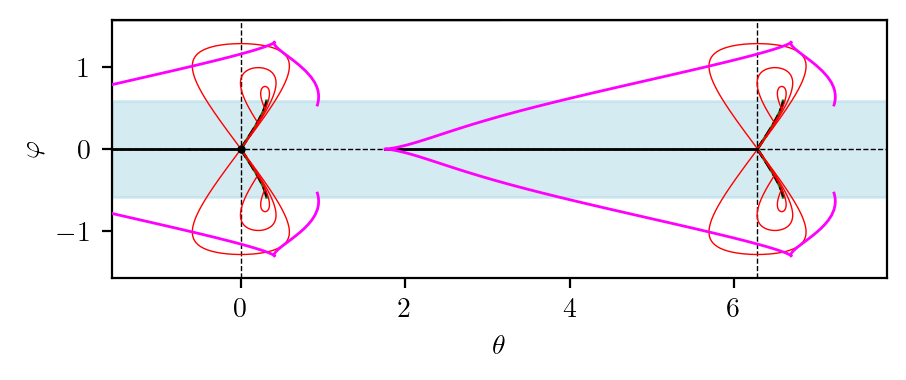

In [44]:
fig2d_synthesis

In [45]:
# add hyperbolic geodesics without loops until the cut locus
αspan = np.linspace(αh_no_loops_1, αh_no_loops_2, 11)

fig2d_synthesis = geodesic.plot(alphas=αspan, tf=t_cut_no_loops, view=PLANE, linewidth=0.5,
                                color=color_hyperbolic, figure=fig2d_synthesis)

for fig3d_synthesis in figs3d_synthesis:
    geodesic.plot(alphas=αspan, tf=t_cut_no_loops, view=SPHERE, linewidth=0.5,
                  color=color_hyperbolic, figure=fig3d_synthesis)

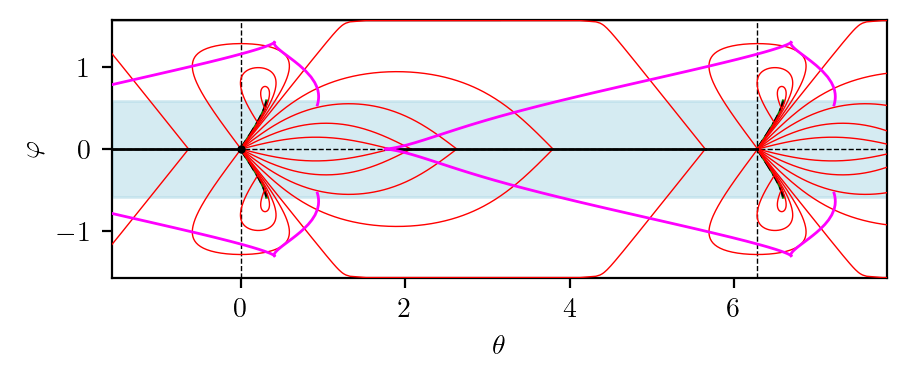

In [46]:
fig2d_synthesis

In [47]:
# add hyperbolic geodesics with loops but not intersection with abnormals until the cut locus
αspan1 = np.linspace(np.pi/2+1e-3, α_loop_return_to_initial_1, 3)
αspan2 = np.linspace(α_loop_return_to_initial_2+1e-3, 3.0*np.pi/2-1e-3, 3)
αspan  = np.concatenate((αspan1, αspan2))

fig2d_synthesis = geodesic.plot(alphas=αspan, tf=t_cut_loops, view=PLANE, linewidth=0.5,
                                color=color_hyperbolic, figure=fig2d_synthesis)

for fig3d_synthesis in figs3d_synthesis:
    geodesic.plot(alphas=αspan, tf=t_cut_loops, view=SPHERE, linewidth=0.5,
                  color=color_hyperbolic, figure=fig3d_synthesis)

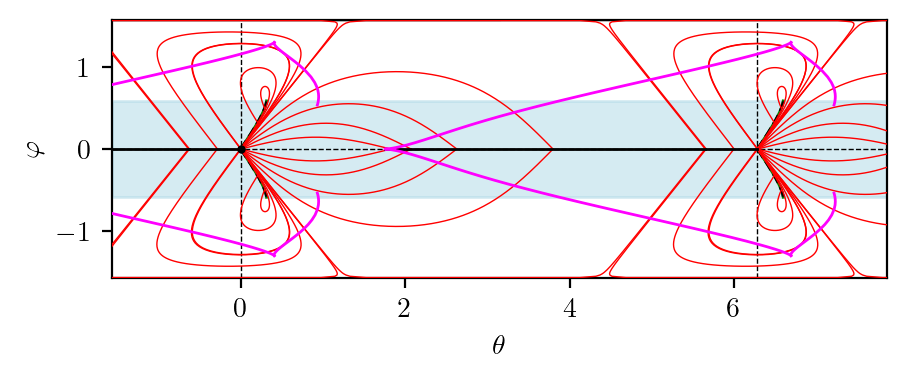

In [48]:
fig2d_synthesis

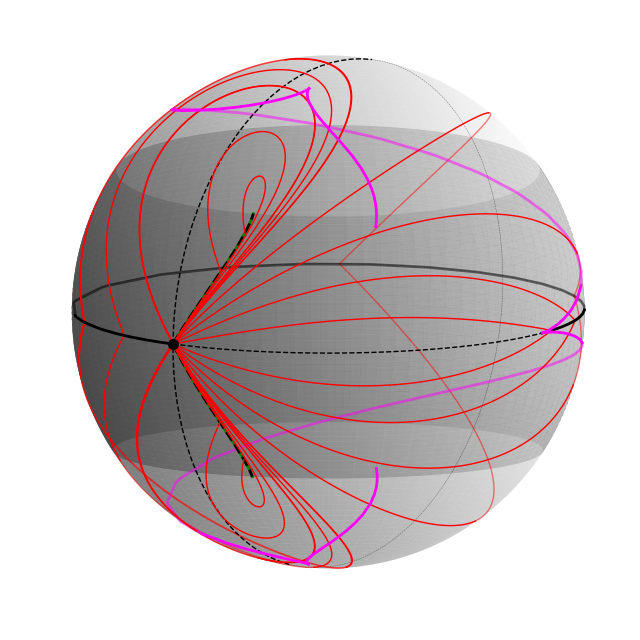

In [49]:
figs3d_synthesis[0]